In [1]:
import pandas as pd 
import numpy as np
from numpy import asarray
from pathlib import Path
import cv2, pickle, csv, os, sys
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline
import xml.etree.ElementTree as ET
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.layers import Dropout, Flatten
from tools import LABELS, SHAPE

In [2]:
# Путь к изображениям
path_img = "original_dataset/keypoint_image_part2/cow/"
dirs_img = os.listdir(path_img)
sorted_files_img = sorted(dirs_img,key=lambda x: int(os.path.splitext(x)[0][3:]))

# Путь к файлам с аннотациями
path_xml = "original_dataset/keypoint_anno_part2/cow/"
dirs_xml = os.listdir(path_xml)
sorted_files_xml = sorted(dirs_xml, key=lambda x: int(os.path.splitext(x)[0][3:]))
list_initial_sizes = []

# Функция изменения разрешения изображении
def resize(size=(300,200), is_gray=False):
    for item_img in sorted_files_img:
        if os.path.isfile(os.path.join(path_img, item_img)):
            im = Image.open(os.path.join(path_img, item_img))
            w, h = im.size
            list_initial_sizes.append((w, h))
            f, e = os.path.splitext(os.path.join(path_img, item_img))
            try:
                filename = f.split('/')[-1]
            except:
                filename = f.split('\r')[-1]
                
            imResize = im.resize(size, Image.ANTIALIAS)
            path2base = os.path.join(Path(f).parent.parent, "gray&resized")
            if os.path.isdir(path2base) == False:
                os.mkdir(path2base)
            
            if is_gray:
                im_gray = ImageOps.grayscale(imResize)
                im_gray.save(os.path.join(path2base, filename+e), 'JPEG', quality=100)
            else:  
                imResize.save(os.path.join(path2base, filename+e), 'JPEG', quality=100)
    print("Finished!")

In [3]:
# Вызов функции изменения разрешения изображении
resize(SHAPE, is_gray=True)

Finished!


In [4]:
# Путь к черно-белым изображениям
path_img = "original_dataset/keypoint_image_part2/gray&resized/"
dirs_img = os.listdir(path_img)
sorted_files_img = sorted(dirs_img,key=lambda x: int(os.path.splitext(x)[0][3:]))

In [5]:
# Создание таблицы изображении и их размеров. Произведение конвертации JPEG файла в STRING(строку)
def add_image2DF():
    data_dict = {
        'images': [],
        'sizes': [],
    }
    for item_img in sorted_files_img:
        if os.path.isfile(os.path.join(path_img, item_img)):  
            an_image = Image.open(os.path.join(path_img, item_img))
            image_sequence = an_image.getdata()
            image_array = np.array(image_sequence)
            
            image_as_str = ''
            for pix in image_array:
                image_as_str += (str(pix) + " ") 
            data_dict['images'].append(image_as_str.strip())
            
    data_dict['sizes'] = list_initial_sizes
    images_df = pd.DataFrame(data_dict)  
    return images_df

images_df = add_image2DF()

In [6]:
# Просмотр заглавления таблицы
images_df.head()

,images,sizes
0,137 142 151 161 159 147 139 138 164 166 153 12...,"(300, 225)"
1,77 69 63 109 162 140 106 126 97 138 203 170 15...,"(300, 200)"
2,6 2 23 101 80 136 90 121 27 138 143 99 5 4 11 ...,"(300, 213)"
3,253 253 253 253 253 253 253 253 253 253 253 25...,"(300, 225)"
4,168 174 174 168 167 172 171 164 159 145 133 13...,"(300, 206)"


In [7]:
# Функции для просмотра изображении
def string2image(string):
    return np.array([int(item) for item in string.split()]).reshape((SHAPE[1], SHAPE[0]))

def plot_cow(image):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(string2image(image), cmap='gray')
        

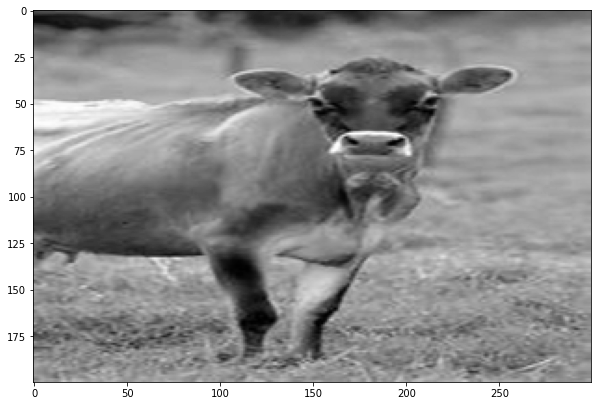

In [8]:
# Просмотр одного изображения по номеру
plot_cow(images_df["images"][30])

In [9]:
# Функция для подготовки csv файла. Произведение конвертации XML файла в CSV файл 
def prepare_csv_file():
    with open("keypoints_dataset.csv", "w+", newline='') as file:
        if len(file.readlines()) > 1:
            file.truncate()
    with open("keypoints_dataset.csv", "a", newline='') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        print()
        writer.writerow(LABELS)
        for xml_item in sorted_files_xml:
            if os.path.isfile(os.path.join(path_xml, xml_item)):
                xml_data = open(os.path.join(path_xml, xml_item)).read()
                root = ET.XML(xml_data)  
                data = []
                for keypoint in root[3]:
                    name, visible, x, y, z = keypoint.items()
                    x = x[1]; y = y[1];
                    data += [x, y]
                writer.writerow(data)
    print("Done!")

In [10]:
# Вызов функции подготовки csv файла
prepare_csv_file()


Done!


In [11]:
# Чтение таблицы "keypoints_dataset.csv"
keypoints_df = pd.read_csv("keypoints_dataset.csv")

In [12]:
# Просмотр заглавления таблицы
keypoints_df.head()

,L_eye_x,L_eye_y,R_eye_x,R_eye_y,L_ear_x,L_ear_y,R_ear_x,R_ear_y,Nose_x,Nose_y,...,R_B_knee_x,R_B_knee_y,L_F_paw_x,L_F_paw_y,R_F_paw_x,R_F_paw_y,L_B_paw_x,L_B_paw_y,R_B_paw_x,R_B_paw_y
0,78.0,73.0,58.0,74.0,90.0,63.0,46.0,61.0,64.0,96.0,...,254.0,140.0,128.0,170.0,0.0,0.0,216.0,179.0,250.0,178.0
1,0.0,0.0,257.0,137.0,0.0,0.0,258.0,117.0,257.0,165.0,...,65.0,132.0,159.0,160.0,190.0,162.0,102.0,159.0,70.0,162.0
2,270.0,81.0,242.0,78.0,286.0,64.0,225.0,71.0,266.0,108.0,...,32.0,145.0,203.0,185.0,194.0,194.0,0.0,0.0,24.0,189.0
3,0.0,0.0,192.0,115.0,182.0,102.0,182.0,115.0,208.0,125.0,...,39.0,157.0,121.0,171.0,134.0,179.0,64.0,176.0,45.0,182.0
4,268.0,44.0,248.0,43.0,276.0,32.0,231.0,34.0,269.0,66.0,...,68.0,155.0,196.0,174.0,218.0,175.0,60.0,187.0,75.0,188.0


In [14]:
# Соединение двух таблиц в одну
keypoints_df["images"] = images_df["images"]
keypoints_df["sizes"] = images_df["sizes"]

In [15]:
# Адаптация аннотации после изменения разрешении изображении
for index in keypoints_df.index:
    for ic, col in enumerate(keypoints_df.columns[:-2]):
        if ic % 2 ==0:
            keypoints_df.iloc[index, ic] /= images_df['sizes'][index][0]
        else:
            keypoints_df.iloc[index, ic] /= images_df['sizes'][index][1]

for index in keypoints_df.index:
    for ic, col in enumerate(keypoints_df.columns[:-2]):
        if ic % 2 ==0:
            keypoints_df.iloc[index, ic] *= SHAPE[0]
        else:
            keypoints_df.iloc[index, ic] *= SHAPE[1]

In [16]:
# Округление данных таблицы и просмотр заглавления
keypoints_df = keypoints_df.round(1)
keypoints_df.head()

,L_eye_x,L_eye_y,R_eye_x,R_eye_y,L_ear_x,L_ear_y,R_ear_x,R_ear_y,Nose_x,Nose_y,...,L_F_paw_x,L_F_paw_y,R_F_paw_x,R_F_paw_y,L_B_paw_x,L_B_paw_y,R_B_paw_x,R_B_paw_y,images,sizes
0,78.0,64.9,58.0,65.8,90.0,56.0,46.0,54.2,64.0,85.3,...,128.0,151.1,0.0,0.0,216.0,159.1,250.0,158.2,137 142 151 161 159 147 139 138 164 166 153 12...,"(300, 225)"
1,0.0,0.0,257.0,137.0,0.0,0.0,258.0,117.0,257.0,165.0,...,159.0,160.0,190.0,162.0,102.0,159.0,70.0,162.0,77 69 63 109 162 140 106 126 97 138 203 170 15...,"(300, 200)"
2,270.0,76.1,242.0,73.2,286.0,60.1,225.0,66.7,266.0,101.4,...,203.0,173.7,194.0,182.2,0.0,0.0,24.0,177.5,6 2 23 101 80 136 90 121 27 138 143 99 5 4 11 ...,"(300, 213)"
3,0.0,0.0,192.0,102.2,182.0,90.7,182.0,102.2,208.0,111.1,...,121.0,152.0,134.0,159.1,64.0,156.4,45.0,161.8,253 253 253 253 253 253 253 253 253 253 253 25...,"(300, 225)"
4,268.0,42.7,248.0,41.7,276.0,31.1,231.0,33.0,269.0,64.1,...,196.0,168.9,218.0,169.9,60.0,181.6,75.0,182.5,168 174 174 168 167 172 171 164 159 145 133 13...,"(300, 206)"


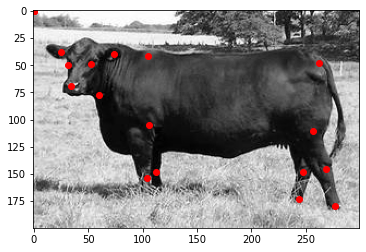

In [61]:
# Проверка правильности произведенных адаптации. Просмотр конечных данных по нумерации.
image_index = 20
keypoint_cols = list(keypoints_df.columns)[:-2]
xy = keypoints_df.iloc[image_index][keypoint_cols].values.reshape((len(images_df.columns), 2))
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(keypoints_df.iloc[image_index]['images']), cmap='gray')

In [21]:
#                            !!! ЧАСТЬ МАШИННОГО ОБУЧЕНИЯ !!!

In [22]:
# Подготовка данных
X = np.stack([string2image(string) for string in keypoints_df['images']]).astype(np.float64)[:, :, :, np.newaxis]

In [23]:
# Подготовка данных
y = np.vstack(keypoints_df[keypoints_df.columns[:-2]].values)

In [24]:
X.shape, X.dtype

((200, 200, 300, 1), dtype('float64'))

In [25]:
y.shape, y.dtype

((200, 40), dtype('float64'))

In [26]:
X_train = X / 255

In [27]:
# Подготовка данных
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)
y_train = output_pipe.fit_transform(y)

In [30]:
# МОДЕЛЬ МАШИННОГО ОБУЧЕНИЯ
model = Sequential()

# Входной слой
model.add(BatchNormalization(input_shape=(SHAPE[1], SHAPE[0], 1)))
model.add(Conv2D(36, (5, 5), kernel_initializer='random_normal'))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Второй слой
model.add(Conv2D(48, (5, 5)))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Третий слой
model.add(Conv2D(64, (5, 5)))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Четвертый слой
model.add(Conv2D(72, (3, 3)))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Пятый слой
model.add(Conv2D(72, (3, 3)))
model.add(Activation('sigmoid'))
model.add(Flatten())

# Шестой слой
model.add(Dense(1000, activation="sigmoid"))

# Седьмой слой
model.add(Dense(180, activation="sigmoid"))

# Восьмой слой
model.add(Dense(y.shape[1]))

In [31]:
# Проведение машинного обучения
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 11
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=2)

Epoch 1/11
80/80 [==============================] - 186s 2s/step - loss: 0.5362 - accuracy: 0.0312 - val_loss: 0.4516 - val_accuracy: 0.0000e+00
Epoch 2/11
80/80 [==============================] - 187s 2s/step - loss: 0.4268 - accuracy: 0.0750 - val_loss: 0.4344 - val_accuracy: 0.1000
Epoch 3/11
80/80 [==============================] - 187s 2s/step - loss: 0.4198 - accuracy: 0.0938 - val_loss: 0.4309 - val_accuracy: 0.1000
Epoch 4/11
80/80 [==============================] - 187s 2s/step - loss: 0.4179 - accuracy: 0.0500 - val_loss: 0.4266 - val_accuracy: 0.0000e+00
Epoch 5/11
80/80 [==============================] - 191s 2s/step - loss: 0.4176 - accuracy: 0.0437 - val_loss: 0.4345 - val_accuracy: 0.0000e+00
Epoch 6/11
80/80 [==============================] - 187s 2s/step - loss: 0.4166 - accuracy: 0.0938 - val_loss: 0.4289 - val_accuracy: 0.1000
Epoch 7/11
80/80 [==============================] - 188s 2s/step - loss: 0.4166 - accuracy: 0.0938 - val_loss: 0.4306 - val_accuracy: 0.1000
E

In [50]:
# Подготовка тестовых данных
img = X_train[0, :, :, :].reshape(1, SHAPE[1], SHAPE[0], 1)
predictions = model.predict(img)

In [54]:
# Предсказание модели
xy_predictions = output_pipe.inverse_transform(predictions).reshape(y.shape[1]/2, 2)

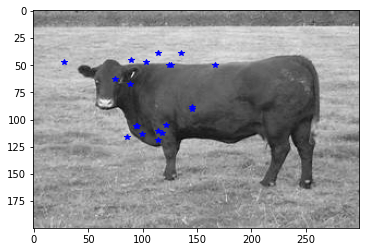

In [55]:
# Проверка предсказании. Вывод данных
plt.imshow(X_train[0, :, :, 0], cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

In [ ]:
# # Для сохранения обученной модели
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

# # Для загрузки ранее сохраненной модели
# loaded_model = pickle.load(open(filename, 'rb'))